# Local join counts

In the following notebook we review the different type of local join counts (LJC) put forward by [Anselin and Li (2019)](https://econpapers.repec.org/article/kapjgeosy/v_3a21_3ay_3a2019_3ai_3a2_3ad_3a10.1007_5fs10109-019-00299-x.htm). LJC focus on spatial phenomenon that take on binary values (e.g. 0 or 1). This suite of exploratory statistics is especially useful to analysts who want to focus on different types of what Anselin and Li call 'co-location'; that is, the presence or absence of specific 0 or 1 values. 

Note that there are several versions of the LJC:

- univariate LJC
- bivariate LJC (case 1)
- bivariate LJC (case 2)
- multivariate LJC

The use case of each of these statistics, as well as their implementation in PySAL, is provided below.

## Univariate LJC

The univariate LJC is a the local version of the 'black-black' (aka 'BB') statistic. This statistic describes the count of the neighbors, $x_j$, of a given unit, $x_i$, that are equal to 1 when the unit is also equal to 1. Formally: 

Eq 1. $$BB_i = x_i \sum_{j} w_{ij} x_j$$

It is important to note that when a given unit $x_i$ is equal to 0, the statistic also becomes 0. Anselin and Li describe the application of this statisttic as:

> Hence, the local join count statistic is only meaningful to assess whether locations with an “event” (i.e., $x_i = 1$ ) are surrounded by more locations with events than would be the case under spatial randomness. *Anselin and Li, 2019, Section 2.2 Page 192*

We can apply the PySAL implementation of the univariate LJC statistic to its original implementation in [GeoDa](https://geodacenter.github.io/workbook/6a_local_auto/lab6a.html#local-join-count-statistic). We first load in the Guerry dataset and convert the column `Donats` to binary column. This new binary column has a value of 1 for the top three groupings of `Donats` based on a Natural Breaks classification method (and 0 for otherwise).

In [1]:
import libpysal
import geopandas as gpd
guerry = libpysal.examples.load_example('Guerry')
guerry_ds = gpd.read_file(guerry.get_path('Guerry.shp'))
guerry_ds['SELECTED'] = 0
guerry_ds.loc[(guerry_ds['Donatns'] > 10997), 'SELECTED'] = 1

We now make a Queen-contiguity weights object to describe the relationship between the units.

In [2]:
w = libpysal.weights.Queen.from_dataframe(guerry_ds)

We can now apply the univariate LJC function on the dataset.

In [3]:
from esda.local_join_count import Local_Join_Count
LJC_uni = Local_Join_Count(connectivity=w).fit(guerry_ds['SELECTED'])

The `LJC` attribute returned from the function counts the total number of local join counts. 

In [4]:
LJC_uni.LJC

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 3., 3., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 2., 0., 3., 0., 0.])

And the `p_sim` attribute contains the p-values obtained from a conditional randomization procedure.

In [5]:
LJC_uni.p_sim

array([  nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan, 0.448,   nan, 0.039, 0.039,   nan, 0.314,
         nan,   nan,   nan,   nan,   nan,   nan, 0.316,   nan, 0.313,
         nan,   nan,   nan,   nan,   nan,   nan, 0.309,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan, 0.446,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan, 0.036,   nan,   nan,   nan,   nan,   nan, 0.141,
         nan, 0.06 ,   nan,   nan])

We can map these values after placing them back into the dataset.

In [6]:
guerry_ds['LJC_UNI'] = LJC_uni.LJC
guerry_ds['LJC_UNI_p_sim'] = LJC_uni.p_sim

From here you may be interested in mapping the LJC...

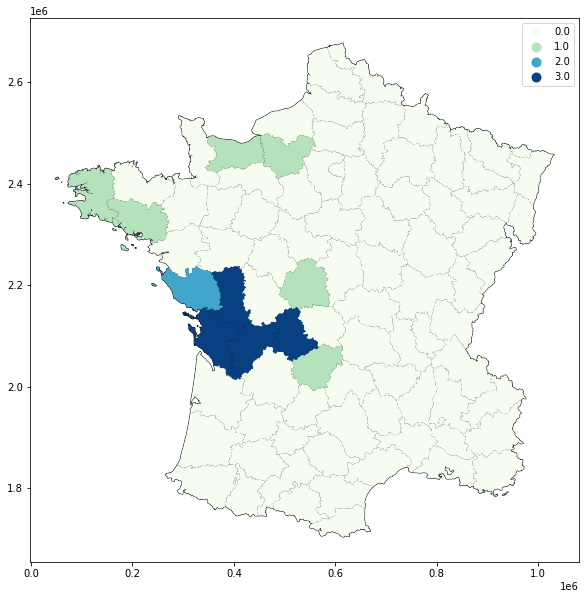

In [7]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
guerry_ds.plot(color='white', edgecolor='black', ax=ax)
guerry_ds.plot(column='LJC_UNI',
               categorical=True,
               cmap='GnBu',
               legend=True, ax=ax)

Or mapping the accompanying significance values below a certain threshold...

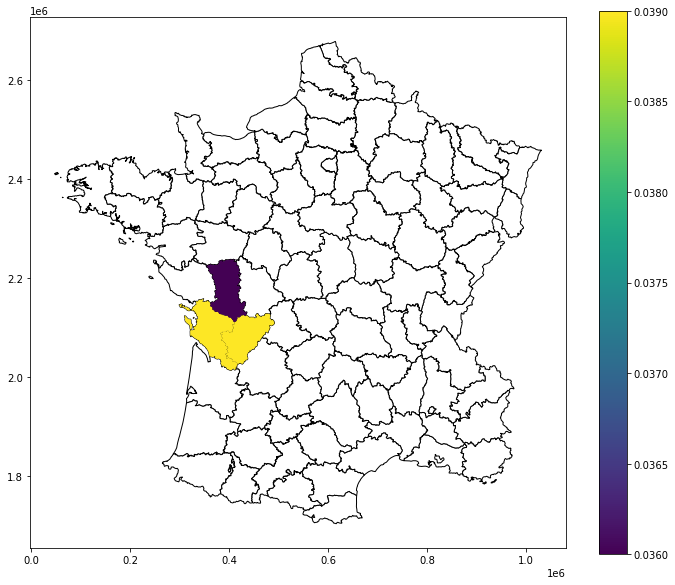

In [8]:
import numpy
guerry_ds['LJC_UNI_p_sim_sig'] = numpy.nan
guerry_ds.loc[(guerry_ds['LJC_UNI_p_sim'] <= 0.05), 'LJC_UNI_p_sim_sig'] = guerry_ds['LJC_UNI_p_sim'] 

import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
guerry_ds.plot(color='white', edgecolor='black', ax=ax)
guerry_ds.plot(column='LJC_UNI_p_sim_sig',
               legend=True, ax=ax)

## Bivariate LJC (case 1)

When considering two variables, say $x$ and $z$, in the bivariate LJC, distinctions need to be made about what spatial pattern is of interest. Anselin and Li define two use cases of the statistic. The first use case is when there is **no in-situ co-location**, or where $x_i$ and $z_i$ **no not** take the same value at $i$ or $j$. More specifically, the bivariate LJC case 1 is interested in when both $x_i$ and $x_j$ equal 1 (i.e. $x_i=x_j=1$) as well as $x_j=0$. Substantively, Anselin and Li explain that case is useful when the phenomenon represented by $x$ and $z$ "cannot occur in the same location". 

Formally, this case is represented as:

Eq 2. $$ BJC_i = x_i (1 - z_i) \sum_{j} w_{ij} z_j (1-x_j)$$

As above, we apply the PySAL implementation of the bivariate LJC case 1 statistic to its original implementation in [GeoDa](https://geodacenter.github.io/workbook/6b_local_adv/lab6b.html#bivariate---no-co-location). Unlike above, we now move to the [Community areas in Chicago dataset (`commpop`)](https://geodacenter.github.io/data-and-lab//). We are going to examine instances of negative spatial autocorrelation, identified by locations where negative population changes (`popneg=1`) surrounded by more locations with positive popuation changes (`popplus=1`).  

In [9]:
import libpysal
import geopandas as gpd
commpop = gpd.read_file("https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/commpop.gpkg")

We again make a Queen-contiguity weights object to describe the relationship between the units.

In [10]:
w = libpysal.weights.Queen.from_dataframe(commpop)

Now we run the `Local_Join_Count_BV` function. **Note that the order of the variables is meaningful!** Changing the order of the variables will change the implied research question.

In [11]:
from esda.local_join_count_bv import Local_Join_Count_BV
LJC_BV_Case1 = Local_Join_Count_BV(connectivity=w).fit(commpop['popneg'], commpop['popplus'], case='BJC')

As before, we can map both the `LJC` and `p_sim` values after placing the results back into the `commpop` dataset.

In [12]:
commpop['LJC_BV_Case1'] = LJC_BV_Case1.LJC
commpop['LJC_BV_Case1_p_sim'] = LJC_BV_Case1.p_sim

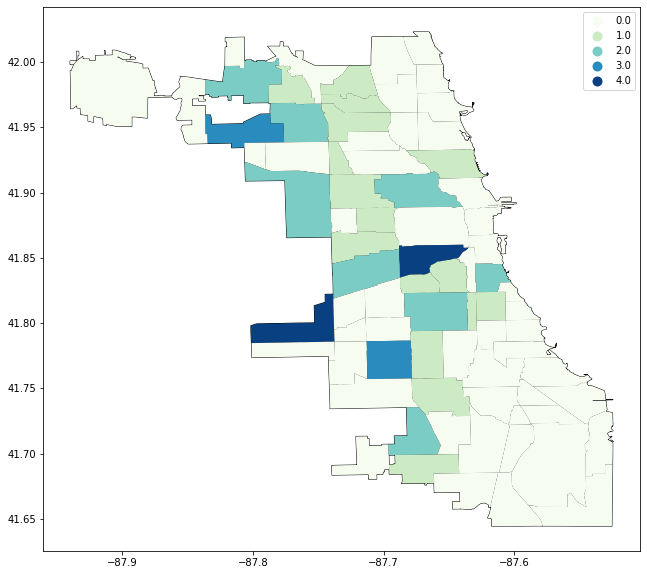

In [13]:
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
commpop.plot(color='white', edgecolor='black', ax=ax)
commpop.plot(column='LJC_BV_Case1',
             cmap='GnBu',
             categorical=True,
             legend=True, ax=ax)

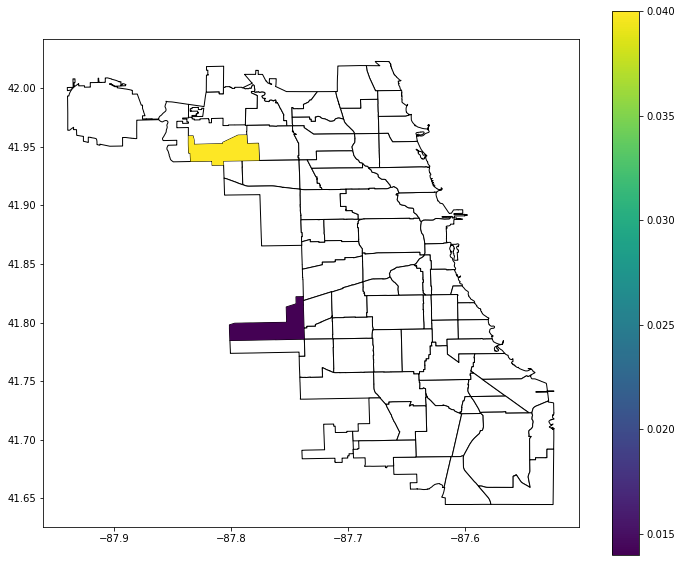

In [14]:
commpop['LJC_BV_Case1_p_sim_sig'] = numpy.nan
commpop.loc[(commpop['LJC_BV_Case1_p_sim'] <= 0.05), 'LJC_BV_Case1_p_sim_sig'] = commpop['LJC_BV_Case1_p_sim'] 

fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
commpop.plot(color='white', edgecolor='black', ax=ax)
commpop.plot(column='LJC_BV_Case1_p_sim_sig',
               legend=True, ax=ax)

## Bivariate LJC (case 2)

We now move on to case 2 of the bivariate LJC. Unlike case 1, case 2 **identifies areas with co-location**. Case 2 is explicitly concerned with instances where $x_i=z_i=1$ as well as $x_j=z_j=1$. Anselin and Li refer to this situation as a **co-location cluster (CLC)**.  We formally write this as:

$$ CLC_i = x_i * z_i \sum_j w_{ij} x_j z_j $$

We return to the Guerry dataset to demonstrate its implementation in PySAL. We are interested in identifying areas that are in the top Quantile for the variables `Infants` (children born out of wedlock) and `Donatns` (donations). We reload the dataset and create the variables below:

In [15]:
guerry = libpysal.examples.load_example('Guerry')
guerry_ds = gpd.read_file(guerry.get_path('Guerry.shp'))
guerry_ds['infq5'] = 0
guerry_ds['donq5'] = 0
guerry_ds.loc[(guerry_ds['Infants'] > 23574), 'infq5'] = 1
guerry_ds.loc[(guerry_ds['Donatns'] > 10973), 'donq5'] = 1

We again make a Queen-contiguity weights object to describe the relationship between the units.

In [16]:
w = libpysal.weights.Queen.from_dataframe(guerry_ds)

We now run the `Local_Join_Count_BV` command, this time changing the `case` argument to `CLC`.

In [17]:
LJC_BV_Case2 = Local_Join_Count_BV(connectivity=w).fit(guerry_ds['infq5'], guerry_ds['donq5'], case='CLC')

As before, we can map the `LJC` and accompanying `p_sim` values.

In [18]:
guerry_ds['LJC_BV_Case2'] = LJC_BV_Case2.LJC
guerry_ds['LJC_BV_Case2_p_sim'] = LJC_BV_Case2.p_sim

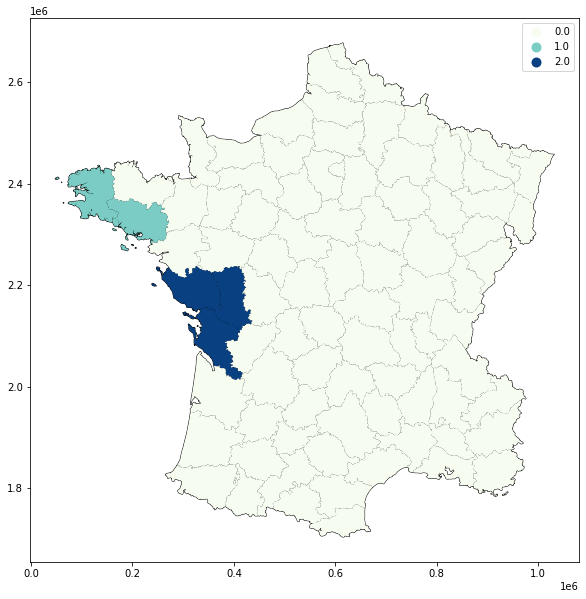

In [19]:
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
guerry_ds.plot(color='white', edgecolor='black', ax=ax)
guerry_ds.plot(column='LJC_BV_Case2',
             cmap='GnBu',
             categorical=True,
             legend=True, ax=ax)

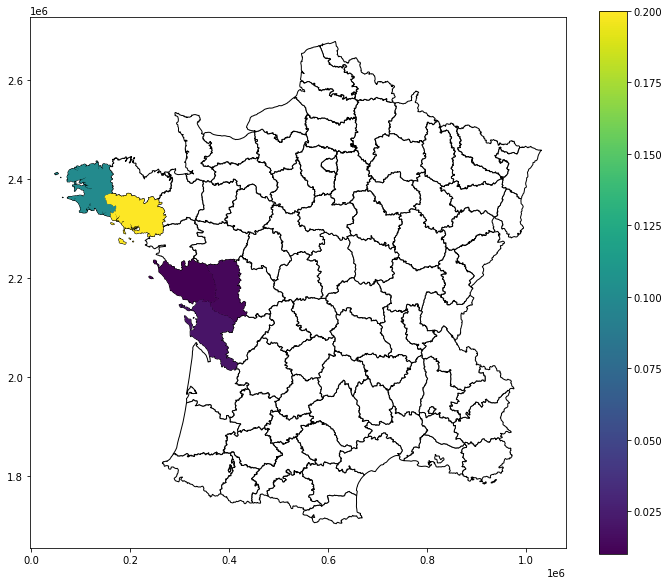

In [20]:
fig,ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
guerry_ds.plot(color='white', edgecolor='black', ax=ax)
guerry_ds.plot(column='LJC_BV_Case2_p_sim',
               legend=True, ax=ax)

## Multivariate LJC

The last LJC to review is the multivariate LJC statistic. This is actually an extension of the bivariate LJC case 2. Rather than considering two variables $x$ and $z$, the multivariate statistic consdiers $m$ variables at each location $i$. All $m$ variables must then meet the co-location criterion of equalling 1. Formally:

$$ CLC_i = \Pi^m_{h=1} x_{hi} \sum_j w_{ij} \Pi^m_{h=1} x_{hj} $$

Anselin and Li state clearly in multiple sources that although the multivariate LJC statistic is a straightforward extension of the bivariate LJC case 2, its substantive meaning is less straightforward. In their own words:

> The extension to multiple binary variables is mathematically straightforward, although maybe conceptually less so. While different combinations are possible, the most practical use case would be one where the interest focuses on the co-location of multiple variables coinciding with co-location for the neighbors. Again, we can refer to this as a co-location cluster. An example would be where binary variables were
constructed from continuous-valued measures for those locations where the observations fall in a pre-specified range, such as the upper decile. The co-location cluster would indicate where such coincidences occur with neighbors that have similar coincidences. However, as the number of variables considered increases, we run into the “curse of dimensionality,” and results would be less meaningful, in the sense that such coincidences would likely be increasingly rare and thus always be indicated as “significant.” *Anselin and Li, 2019, Section 3.3, Page 198*

We demonstrate this problem by extending the example from the bivariate LJC case 2. We add a third variable that counts the number of suicides in an area (`Suicids`). The substnative quesiton of interest is now seeking areas that are in the highest Quantile for the number of births out of wedlock, the number of donations to the poor, and the number of suicides. We reload the Guerry dataset and create the variables:

In [21]:
guerry = libpysal.examples.load_example('Guerry')
guerry_ds = gpd.read_file(guerry.get_path('Guerry.shp'))
guerry_ds['infq5'] = 0
guerry_ds['donq5'] = 0
guerry_ds['suic5'] = 0
guerry_ds.loc[(guerry_ds['Infants'] > 23574), 'infq5'] = 1
guerry_ds.loc[(guerry_ds['Donatns'] > 10973), 'donq5'] = 1
guerry_ds.loc[(guerry_ds['Suicids'] > 55564), 'suic5'] = 1

And agian create the Queen contiguity spatial weights object.

In [22]:
w = libpysal.weights.Queen.from_dataframe(guerry_ds)

We now load in the `Local_Join_Count_MV` function and apply it to all three variables:

In [23]:
from esda.local_join_count_mv import Local_Join_Count_MV
LJC_MV = Local_Join_Count_MV(connectivity=w).fit([guerry_ds['infq5'], guerry_ds['donq5'], guerry_ds['suic5']])

Before proceeding to mapping, it is worthwhile to check if there are **any** areas that meet the criterion described above. 

In [24]:
LJC_MV.LJC

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Because there are no areas that meet the criteria, no areas will have a significance value.

In [25]:
LJC_MV.p_sim

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

Nevertheless, it is important to recognize tht such a finding **may still be important as a 'null' result!** 